# ULMFiT for Airline Tweet Sentiment Analysis

This notebook demonstrates how to use an ULMFiT model to perform sentiment analysis for Twitter US Airline Sentiment Dataset (available at https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv) via Fast.ai's library

This notebook was run in the Google Colab platform.

I have taken help from the following sources:


https://docs.fast.ai/text.html#Quick-Start:-Training-an-IMDb-sentiment-model-with-ULMFiT

https://gist.github.com/manojps/ffd382ee97d173f14f9ac5075fe1d1af

https://www.kaggle.com/wesleyliao3/sentiment-analysis-using-rnn-lstm-ulmfit

# Setup

Set up the Google Colab and mount my Google drive. I did this to speed up the training process.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/'  #change dir to your project folder

Mounted at /content/gdrive


Import necessary packages.

In [0]:
# import basic pakages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

Import fastai.

In [3]:
# import fastai
! curl https://course.fast.ai/setup/colab | bash
from fastai.text import *

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   3962      0 --:--:-- --:--:-- --:--:--  3962
Updating fastai...
Done.


# Prepare data and observe data

In [4]:
# read in twitter dataset and view first a few lines
url = 'https://raw.githubusercontent.com/alexiswang/NLP/master/Tweets.csv'
tweets=pd.read_csv(url)
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


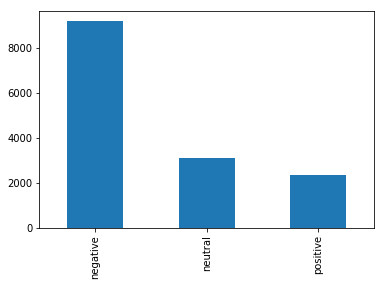

In [5]:
tweets['airline_sentiment'].value_counts().plot(kind='bar')

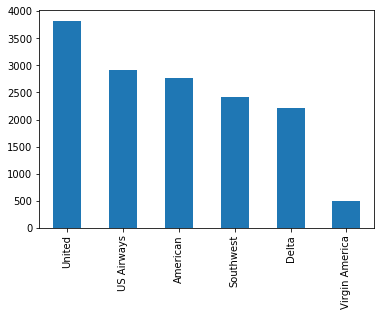

In [6]:
tweets['airline'].value_counts().plot(kind='bar')

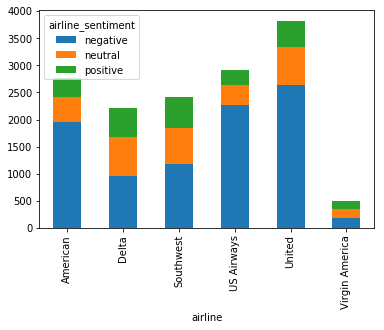

In [7]:
tweets.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [0]:
# create a new dataframe including the text and label(sentiment)
data = pd.DataFrame()
data['sentiment'] = tweets.airline_sentiment
data['text'] = tweets.text

In [9]:
# view first a few lines of the new dataframe
data.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
# split the dataset for trainging and validation purpose
train, val = train_test_split(data)

# Language Model

According to the fastai documentation, one needs to get the data ready for modelling first. There are several ways of doing so, here I used the method from_df of the TextLMDataBunch to get the data ready for a language model. And the TextClasDataBunch was employed to get the data ready for a text classifier classes,

ref https://docs.fast.ai/text.html#Quick-Start:-Training-an-IMDb-sentiment-model-with-ULMFiT

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df('.',train,val)
# Classifier model data
data_clas = TextClasDataBunch.from_df('.',train,val)

It will save some time to save the data and reload it whenever needed, especially if one is running this on your own computer. Bt when I ran the code on Colab, this is actually very fast. So we don't need it here.

In [0]:
# save the language model data and the classifier model data in google drive
# root_dir = "/content/gdrive/My Drive/"
# data_lm.save(root_dir+'data_lm_export.pkl')
# data_clas.save(root_dir+'data_clas_export.pkl')

In [0]:
# load the language model data and the classifier model data from google drive
# root_dir = "/content/gdrive/My Drive/"
# data_lm = load_data(root_dir,'data_lm_export.pkl')
# data_clas = load_data(root_dir,'data_clas_export.pkl', bs=16)

In [14]:
# show a few line of the language model data
data_lm.show_batch()

idx,text
0,"' 😘 xxbos @americanair \n xxmaj not giving you a hard time ... xxmaj just looking for basic customer service after xxup aa lost my bag . xxup eta on it 's return , please xxrep 8 ? xxbos @united xxmaj call customer service and of course they just say "" there s nothing we can do "" and then offer a transfer and disconnect the line . xxbos"
1,"? xxbos @united this means within one week i will have filed 2 compensation complaints to your website xxbos xxmaj why does n't @americanair provide a means for dialogue ? xxmaj what is the fear that xxunk this decision ? # worstcustomerserviceever xxbos @usairways trying to check in online for a flight tomorrow . xxmaj tried computer , tablet , and phone . got error message on all devices ?"
2,5 crew members to send pics in the chairs get xxup free tickets to visit us . # xxunk # xxunk xxbos @united my golf bag did n't have a top cover + xxunk said they could n't check without a type of cover or wrap . xxmaj forced to leave the bag ... xxbos @united - xxmaj ridiculous to fly outdated xxunk anywhere much less btwn xxup iah and
3,"you would try to blame weather to deny us vouchers in xxmaj phoenix . xxmaj totally false , was a crew issue . xxbos @americanair ah if only we could get through . xxmaj we 've tried for over 2 hrs . xxmaj can we call @united ? xxbos @americanair xxunk . http : / / t.co / xxunk xxbos @usairways xxmaj wife and i flew to xxmaj italy recently"
4,reflight xxmaj booking xxmaj problems . missed the only flight to xxup sti . awful . xxbos @united xxmaj do you have any flights with lie flat seating from xxup stl to xxup pdx around the date of xxmaj march 5 ? xxbos @usairways i will xxup never fly us airways or american again and i will share this nightmare of a story to all the many others we know


In [15]:
# show a few line of the classifier model data
data_clas.show_batch()

text,target
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @southwestair i had to travel to xxmaj savannah , xxup ga , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
xxbos @united : xxmaj unhappy with xxmaj united 's service ? \n \n xxmaj read xxmaj xxunk xxmaj xxunk 's open letter to xxup ual 's xxup ceo . \n \n xxmaj leave a comment or xxup rt . \n \n http : / / t.co / xxunk,negative


In [0]:
# !wget http://files.fast.ai/models/wt103_v1/lstm_wt103.pth
# !wget http://files.fast.ai/models/wt103_v1/itos_wt103.pkl

Now that the data is prepared, one can define and fine-tune the language model. The AWD_LSTM model is used by default with pre-trained weights.

In [0]:
# initialize the language model
learn = language_model_learner(data_lm,AWD_LSTM, drop_mult=0.5)

In [18]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.926075,4.171953,0.234821,00:10


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


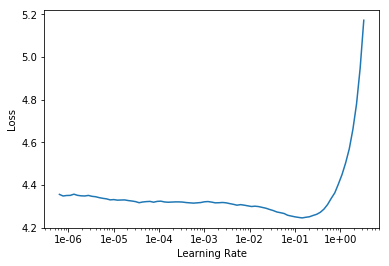

In [20]:
learn.recorder.plot()

In [21]:
# fine tune the model by unfreezing up to the last layer
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.173508,3.924900,0.263382,00:11


In [22]:
# fine tune the model by unfreezing up to the last two layers
learn.freeze_to(-2)
learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.908447,3.775665,0.283514,00:11


In [23]:
learn.unfreeze()
learn.fit_one_cycle(1,slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.729923,3.692593,0.291986,00:14


In [0]:
# save the fine-tuned language model
learn.save_encoder('twitter_encoder')                      

# Classifier Model

In [0]:
# Initialize classifier model using the fine-tuned language model
learn_c = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn_c.load_encoder('twitter_encoder')

The following process is similar to that for the language model. 
First train the model to predict the ssentiment.

In [26]:
learn_c.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.604884,0.555185,0.762842,00:13


Then unfreeze the model and fint tune it.

In [27]:
learn_c.freeze_to(-1)
learn_c.fit_one_cycle(1, slice(5e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.636653,0.530915,0.781694,00:13


In [28]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(5e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.556088,0.486397,0.807923,00:15


In [29]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(5e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.557990,0.500466,0.812022,00:30


After gradually unfreeze and fine-tuning, the modell can achieve an accuracy of 0.81, which is similar to what Manoj and Wesley found in their models.

# Prediction

To predict for a single sentence, one can use predict(). If a full dataset is to be predicted, get_preds() can be used.

In [34]:
# Example of prediction on a single tweet
learn_c.predict('The service is not satisfying')

(Category negative, tensor(0), tensor([0.7998, 0.1620, 0.0382]))